In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)

In [3]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
raw_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,4,5,13.00,32.00,0,0,0


# 시간에 따른 자전거 대여량 변화

<AxesSubplot:xlabel='datetime'>

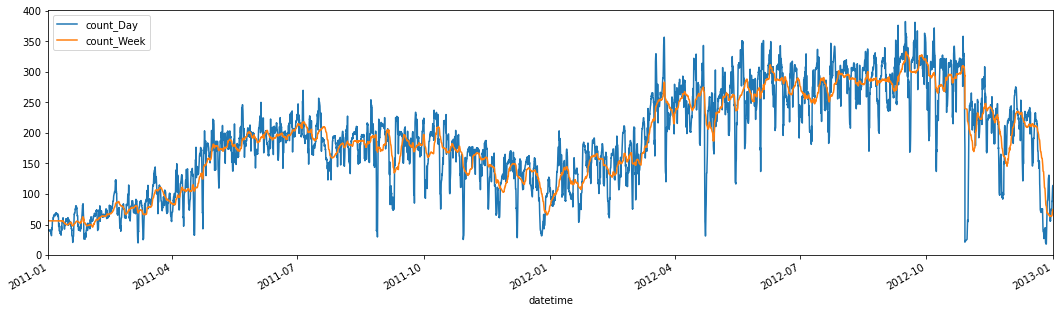

In [4]:
# 일평균 및 주평균 수요량 변화
raw_fe.plot(x='datetime', y=['count_Day', 'count_Week'], figsize=(18,5), xlim=('2011-01', '2013-01'))

# 계절, 날씨, 휴일에 따른 자전거 대여량 변화

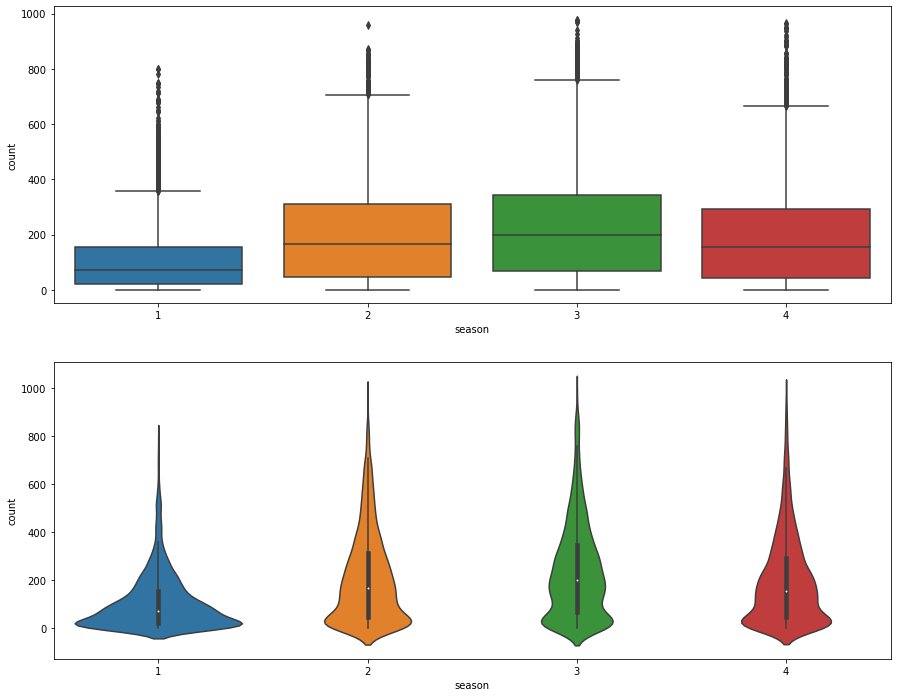

In [5]:
# boxplot과 violinplot으로 본 계절에 따른 수요량 변화
# 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
fig, axs = plt.subplots(2,1, figsize=(15,12))
sns.boxplot(x='season', y='count',  data=raw_fe, ax=axs[0])
sns.violinplot(x='season', y='count', data=raw_fe, ax=axs[1])
plt.show()

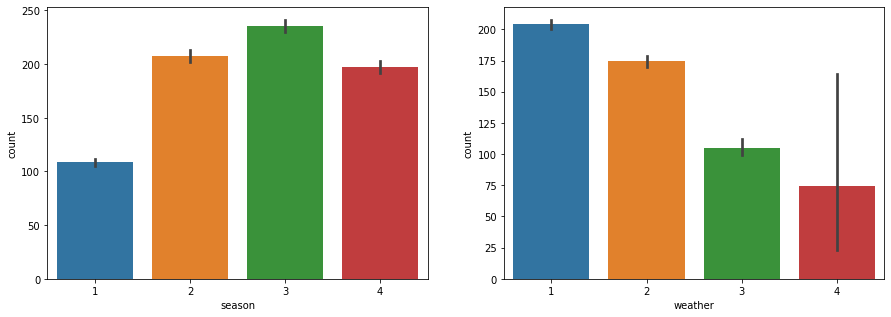

In [6]:
# 왼쪽은 계절, 오른쪽은 날씨에 따른 자전거 수요량 변화
# 1 = 날씨 좋음, 2 = 날씨 적당함, 3 = 날씨 별로 안좋음, 4 = 날씨 안좋음
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.barplot(x='season', y='count', data=raw_fe, ax=axs[0])
sns.barplot(x='weather', y='count', data=raw_fe, ax=axs[1])
plt.show()

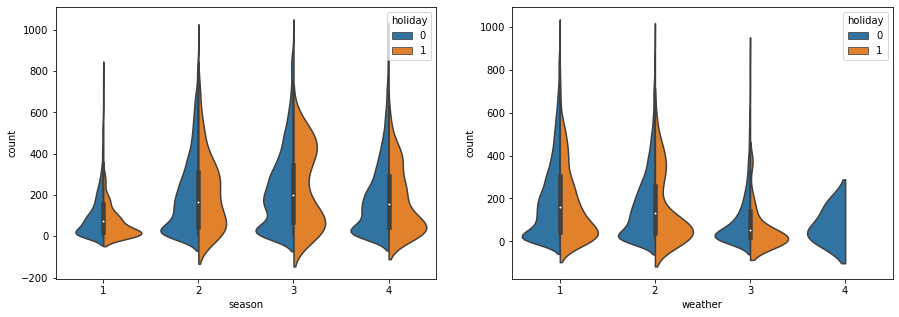

In [7]:
# violinplot으로 그린 계절, 날씨 휴일에 따른 자전거 수요량 변화
plt.figure(figsize=(15,5))
sns.violinplot(x='season', y='count', hue='holiday', data=raw_fe, split=True,
              ax=plt.subplot(121))
sns.violinplot(x='weather', y='count', hue='holiday', data=raw_fe, split=True,
              ax=plt.subplot(122))
plt.show()

# 온도에 따른 자전거 대여량 변화

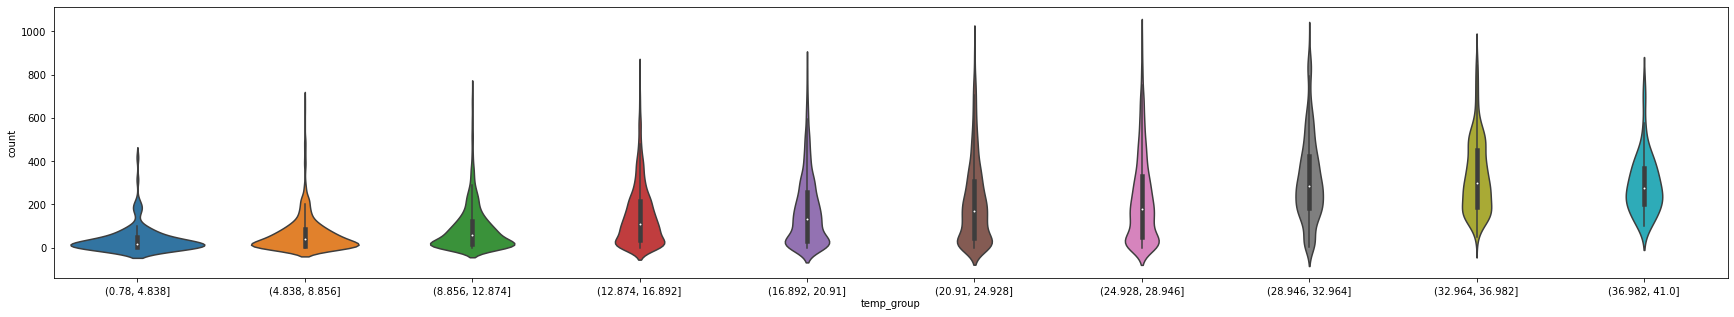

In [8]:
plt.figure(figsize=(30,5))
sns.violinplot(x='temp_group', y='count', data=raw_fe)
plt.show()

<AxesSubplot:title={'center':'count'}, xlabel='temp_group'>

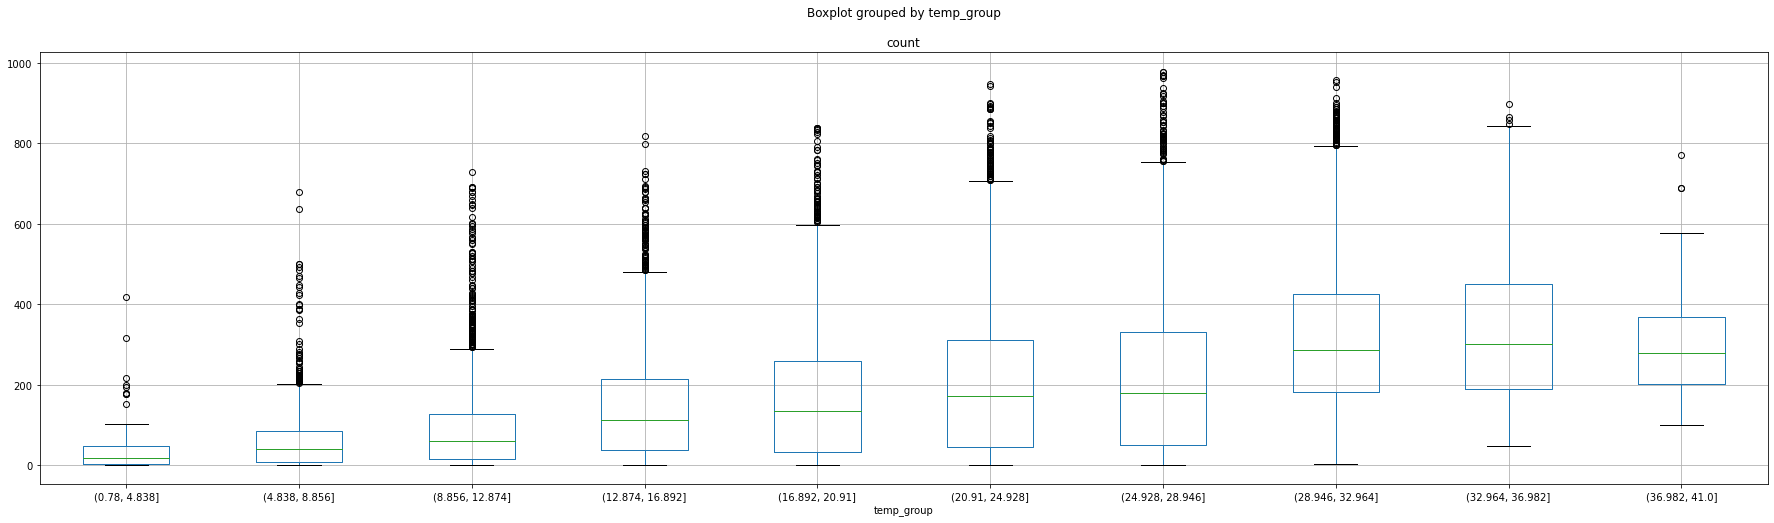

In [9]:
raw_fe.boxplot(column='count', by='temp_group', figsize=(30,8))

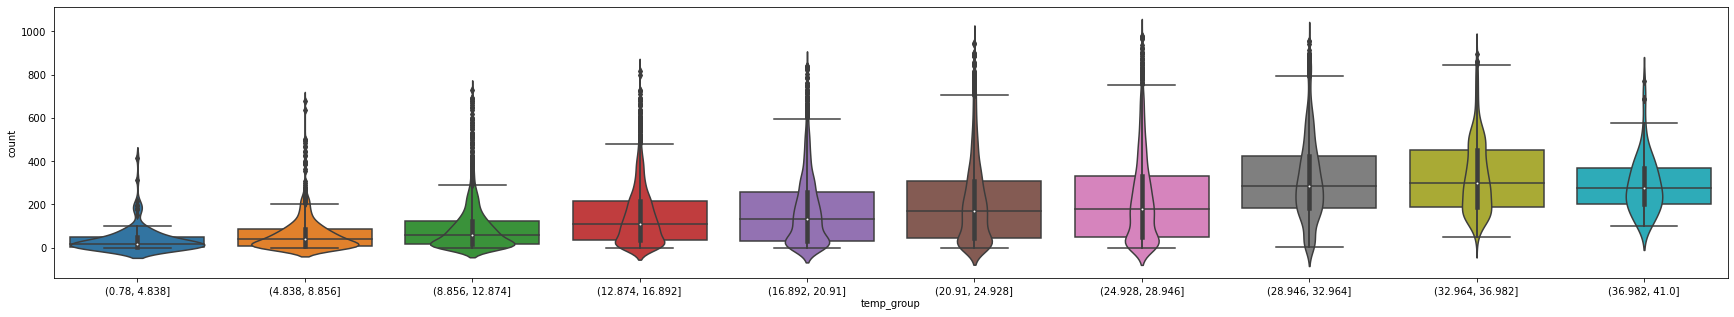

In [10]:
plt.figure(figsize=(30,5))
ax = sns.violinplot(x='temp_group', y='count', data=raw_fe)
ax = sns.boxplot(x='temp_group', y='count', data=raw_fe)
plt.show()

# 월별 자전거 대여량 

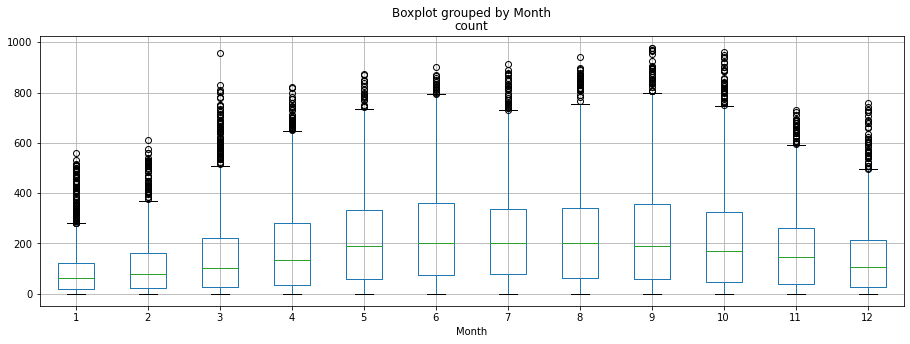

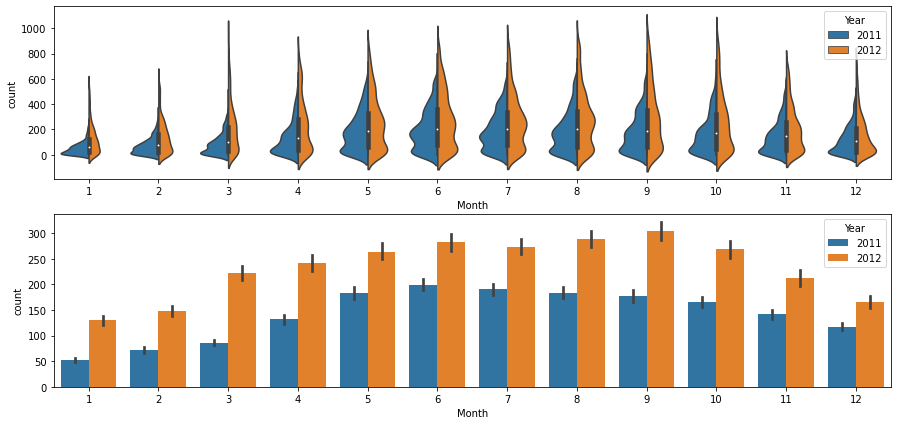

In [11]:
raw_fe.boxplot(column='count', by='Month', figsize=(15,5))

plt.figure(figsize=(15,7))
sns.violinplot(x='Month', y='count', hue='Year', split=True, data=raw_fe, ax=plt.subplot(211))
# barplot의 y축은 가중평균값임
sns.barplot(x='Month', y='count', hue='Year', data=raw_fe, ax=plt.subplot(212))
plt.show()

# 온도, 습도, 풍속에 따른 자전거 대여량 변화

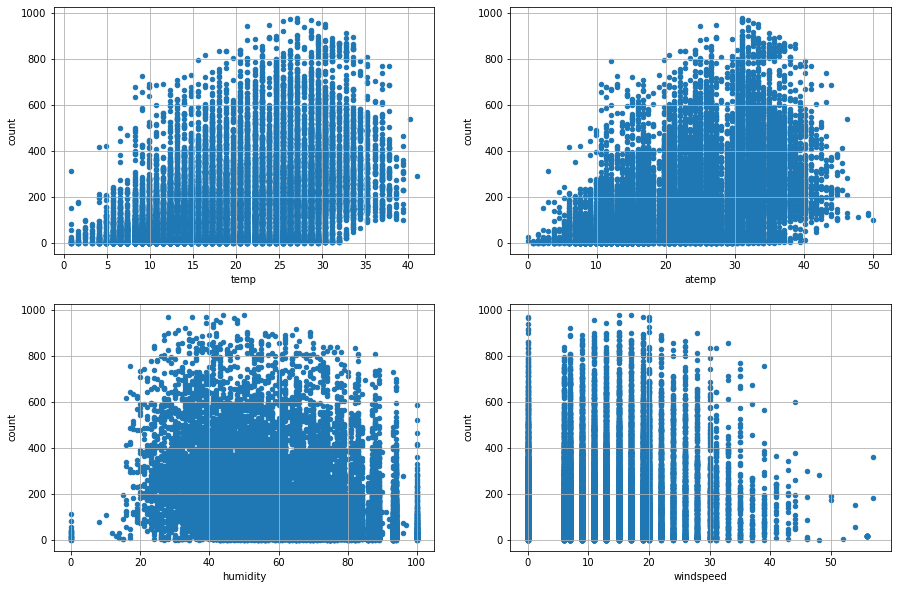

In [12]:
plt.figure(figsize=(15,10))
raw_fe.plot.scatter(x='temp', y='count', grid=True, ax=plt.subplot(221))
raw_fe.plot.scatter(x='atemp', y='count', grid=True, ax=plt.subplot(222))
raw_fe.plot.scatter(x='humidity', y='count', grid=True, ax=plt.subplot(223))
raw_fe.plot.scatter(x='windspeed', y='count', grid=True, ax=plt.subplot(224))
plt.show()

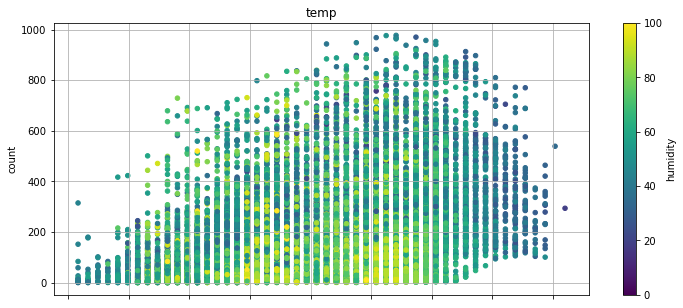

In [13]:
raw_fe.plot.scatter(x='temp', y='count', c='humidity', grid=True, colormap = 'viridis', figsize=(12,5))
plt.title('temp')
plt.show()

# 월별 온도, 습도에 따른 자전거 대여량 변화

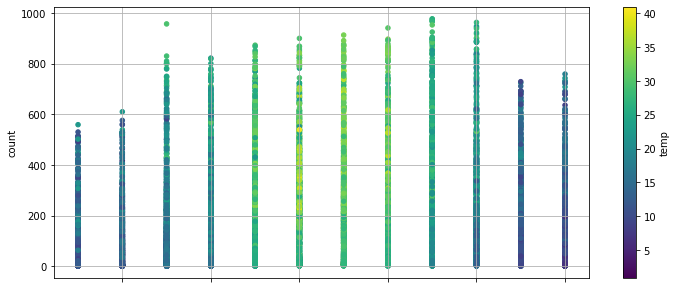

In [14]:
raw_fe.plot.scatter(y='count', x='Month', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

# 2011년 월별 자전거 대여량 평균 변화

In [15]:
# 2011년 데이터에서 해당 월의 row개수를 보여줍니다.
raw_fe[raw_fe['Year']==2011]['Month'].value_counts().sort_index()

1     744
2     672
3     744
4     720
5     744
6     720
7     744
8     744
9     720
10    744
11    720
12    744
Name: Month, dtype: int64

In [16]:
# 2011년 1월 자전거 수요량의 평균을 구합니다.
raw_fe[(raw_fe['Year']==2011) & (raw_fe['Month']==1)][['count']].mean()

count   52.25
dtype: float64

In [17]:
# 2011년 월별 자전거 대여량의 평균을 구합니다.
raw_fe[raw_fe['Year']==2011].groupby(by='Month')[['count']].mean()

,count
Month,
1,52.25
2,71.84
3,86.17
4,131.78
5,182.56
6,199.32
7,189.97
8,184.00
9,176.99


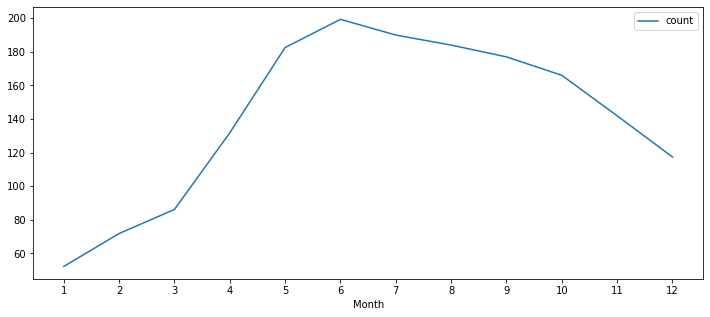

In [18]:
# 2011년 월별 자전거 대여량 평균 시각화
raw_fe[raw_fe['Year']==2011].groupby(by='Month')[['count']].mean().plot(figsize=(12,5))
plt.xticks(raw_fe[raw_fe['Year']==2011].groupby(by='Month')[['count']].mean().index)
plt.show()

# 시간대별 자전거 대여량 평균 변화

<AxesSubplot:xlabel='Hour', ylabel='count'>

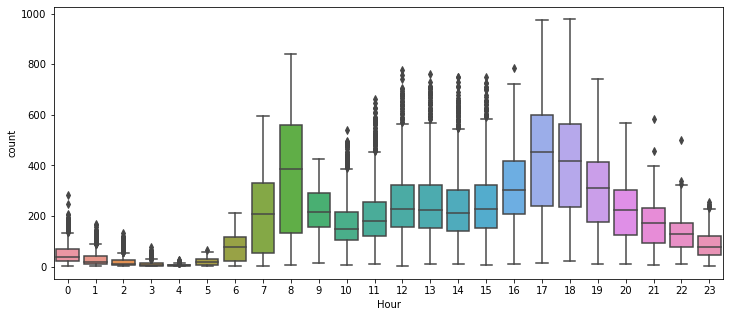

In [19]:
# boxplot으로 그린 시간대별 자전거 대여량
plt.figure(figsize=(12,5))
sns.boxplot(x='Hour', y='count', data=raw_fe)

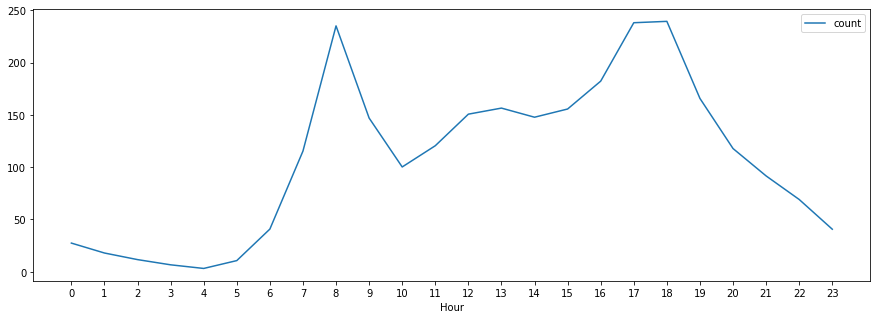

In [20]:
# 봄철 시간대별 자전거 수요량 평균
raw_fe[raw_fe['season']==1].groupby(by='Hour')[['count']].mean().plot(figsize=(15,5))
plt.xticks(raw_fe[raw_fe['season']==1].groupby(by='Hour')[['count']].mean().index)
plt.show()

In [21]:
# 계절별로 시간대별 자전거 대여량 평균 데이터프레임을 생성합니다.
spring = raw_fe[raw_fe['season']==1].groupby(by='Hour')[['count']].mean()
summer = raw_fe[raw_fe['season']==2].groupby(by='Hour')[['count']].mean()
fall = raw_fe[raw_fe['season']==3].groupby(by='Hour')[['count']].mean()
winter = raw_fe[raw_fe['season']==4].groupby(by='Hour')[['count']].mean()
display_side_by_side(spring, summer, fall, winter)

,count
Hour,
0,27.40
1,17.91
2,11.60
3,6.62
4,3.15
5,10.66
6,40.79
7,115.39
8,235.17


In [22]:
# 위의 데이터프레임을 하나로 합찹니다.
season_count = pd.concat([spring, summer, fall, winter], axis=1)
season_count.columns = ['spring', 'summer', 'fall', 'winter']
season_count.head()

,spring,summer,fall,winter
Hour,,,,
0,27.40,56.84,73.56,50.53
1,17.91,35.22,43.51,35.79
2,11.60,23.20,30.58,23.48
3,6.62,11.25,15.75,11.86
4,3.15,6.21,8.24,7.27


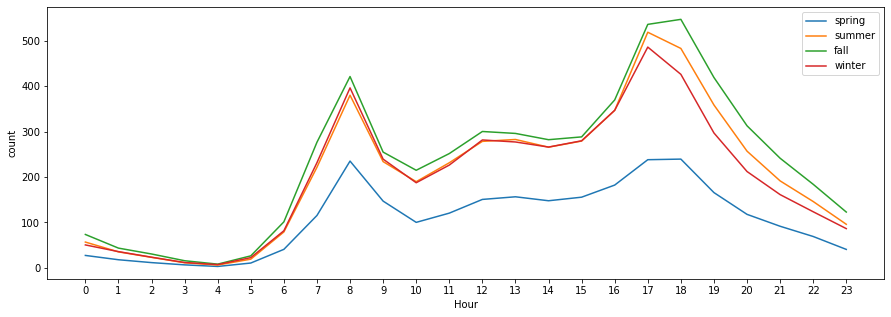

In [23]:
# 각계절 시간대별로 자전거 대여량 평균 시각화
season_count.plot(figsize=(15,5))
plt.xticks(season_count.index)
plt.ylabel('count')
plt.show()

In [24]:
# 날씨별로 시간대별 자전거 대여량 평균 데이터프레임을 생성합니다.
# weather=4에는 자전거를 빌린 사람이 거의 없습니다.
good = raw_fe[raw_fe['weather']==1].groupby(by='Hour')[['count']].mean()
mild = raw_fe[raw_fe['weather']==2].groupby(by='Hour')[['count']].mean()
not_bad = raw_fe[raw_fe['weather']==3].groupby(by='Hour')[['count']].mean()

# 위의 데이터프레임을 하나로 합찹니다.
weather_count = pd.concat([good, mild, not_bad], axis=1)
weather_count.columns = ['good', 'mild', 'not_bad']
weather_count.head()

,good,mild,not_bad
Hour,,,
0,59.16,47.23,25.42
1,34.15,35.54,16.24
2,22.15,24.71,13.69
3,11.72,12.05,6.84
4,6.38,6.64,4.71


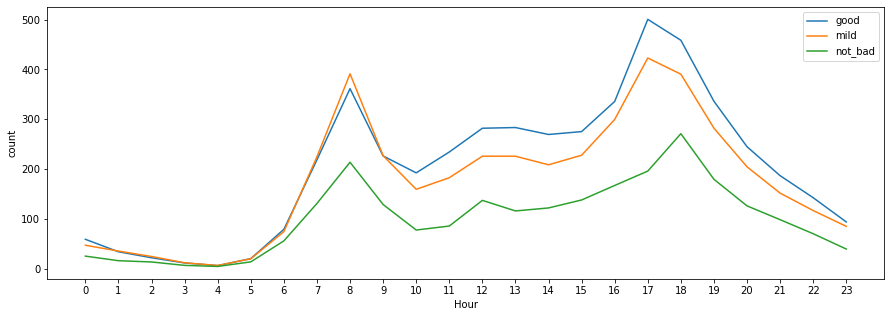

In [25]:
# 각날씨 시간대별로 자전거 대여량 평균 시각화
weather_count.plot(figsize=(15,5))
plt.xticks(weather_count.index)
plt.ylabel('count')
plt.show()

# 온도, 습도, 풍속별 자전거 대여량 평균 변화

<AxesSubplot:xlabel='temp'>

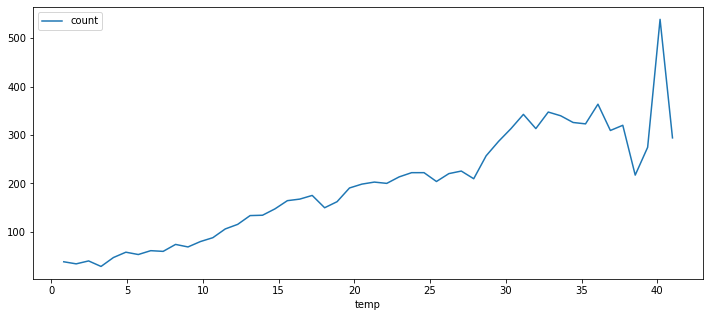

In [26]:
# 온도별 자전거 대여량 평균 시각화
temp_count = raw_fe.groupby(by='temp')[['count']].mean()
temp_count.plot(figsize=(12,5))

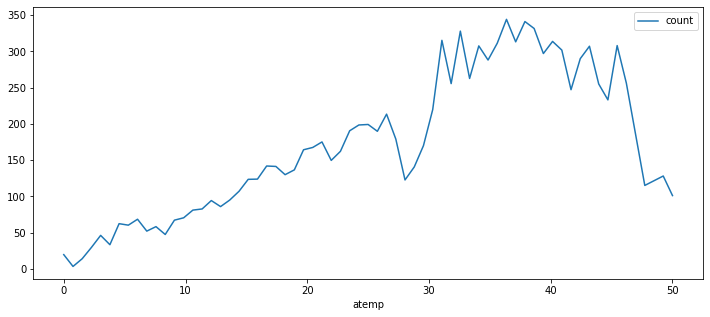

In [27]:
# 체감온도별 자전거 대여량 평균 시각화
atemp_count = raw_fe.groupby(by='atemp')[['count']].mean()
atemp_count.plot(figsize=(12,5))
plt.show()

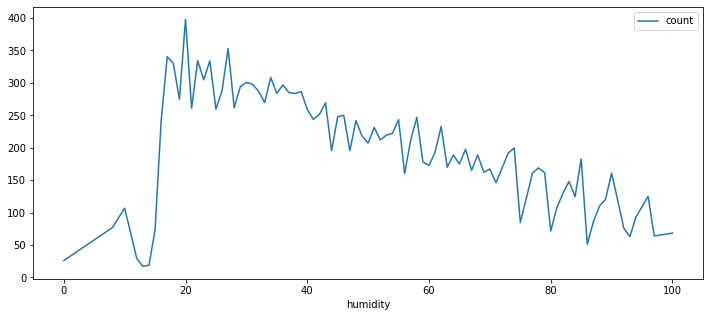

In [28]:
# 습도별 자전거 대여량 평균 시각화
hum_count = raw_fe.groupby(by='humidity')[['count']].mean()
hum_count.plot(figsize=(12,5))
plt.show()

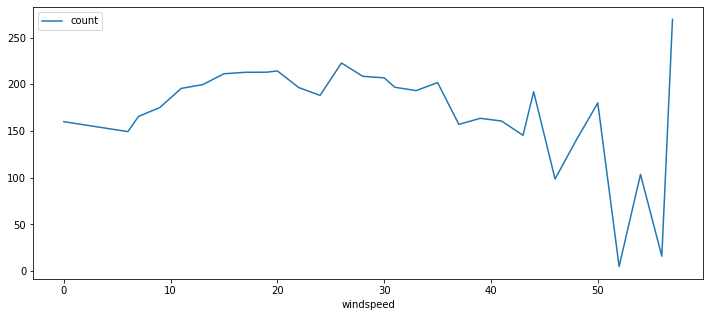

In [29]:
# 풍속별 자전거 대여량 평균 시각화
ws_count = raw_fe.groupby(by='windspeed')[['count']].mean()
ws_count.plot(figsize=(12,5))
plt.show()

In [39]:
raw_fe[['temp', 'atemp']][raw_fe['season']==1].mean()

temp    12.18
atemp   14.79
dtype: float64

In [45]:
raw_fe.groupby('season')['count'].agg(['mean', max])

,mean,max
season,,
1,108.72,801
2,208.02,957
3,235.23,977
4,197.20,967
